# Evaluation and model interpretation

In [1]:
import pandas as pd
import numpy as np
import h5py

import torch
from dataclasses import make_dataclass

from importlib import reload
from src.datasets import UKBSnpLevelDatasetH5OneHot

from src.util import load_config
from src.graphs import GeneOntology
from src.vnn_trainer import GenoVNNLightning, FastVNNLightning, FastVNNLitReg

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
torch.cuda.is_available()

True

In [3]:
config_file = "src/config/gout_config.yaml"
config = load_config(config_file)
config["feature_dim"] = 3

In [4]:
config

{'onto': '../ontology.txt',
 'train': '../labels.csv',
 'label_col': 'gout',
 'mutations': '../genotype_data.h5',
 'epoch': 5,
 'lr': 0.0001,
 'wd': 0.001,
 'alpha': 0.3,
 'batchsize': 256,
 'modeldir': '/model_test/',
 'cuda': 0,
 'gene2id': '../ukb_snp_ids.csv',
 'genotype_hiddens': 4,
 'optimize': 1,
 'zscore_method': 'auc',
 'std': '/model_test/std.txt',
 'patience': 30,
 'delta': 0.001,
 'min_dropout_layer': 10,
 'dropout_fraction': 0.25,
 'lr_step_size': 4,
 'activation': 'leaky_relu',
 'task': 'classification',
 'onehot': True,
 'num_workers': 8,
 'run_name': 'gout',
 'num_covariates': 2,
 'feature_dim': 3}

In [5]:
args = make_dataclass(
    "DataclassFromConfig", [(k, type(v)) for k, v in config.items()]
)(**config)


In [6]:
gene_bim_file = "/cluster/project/beltrao/gankin/vnn/data/ukb_gene.bim"
gene_bim_df = pd.read_csv(gene_bim_file, sep="\t")

snp_id_map = {
    snp: ind
    for snp, ind in zip(
        gene_bim_df["snp"].unique(), range(0, len(gene_bim_df["snp"].unique()))
    )
}

graph = GeneOntology(
    snp_id_map,
    "/cluster/project/beltrao/gankin/vnn/snp_vnn/data/NEST_UKB_snp_onto.txt",
    child_node="snp",
)

/scratch/tmp.15978012.dgankin/ipykernel_1910081/1656017962.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gene_bim_df = pd.read_csv(gene_bim_file, sep="\t")


There are 1 roots: NEST
There are 18074 terms
There are 1 connected components


In [7]:
go_vnn_model = FastVNNLightning.load_from_checkpoint("/cluster/project/beltrao/gankin/vnn/snp_vnn/data/checkpoints/gout/epoch=6-step=10682.ckpt", args = args, graph=graph)

Constructing first NN layer
Constructing NN graph


In [8]:
from captum.attr import IntegratedGradients

/cluster/project/beltrao/gankin/software/miniconda3/envs/mamba_env/envs/vnn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
def create_random_input(batch_size=64):
    x = torch.randint(0, 3, (batch_size, 429371))
    data = x.long()  # Ensure compatibility for one_hot

    # One-hot encode the data (0, 1, or 2) across a new last dimension
    data = torch.nn.functional.one_hot(data, num_classes=3).float()

    baseline = torch.zeros_like(x).long()
    baseline_data = torch.nn.functional.one_hot(baseline, num_classes=3).float()

    age = torch.randint(1930, 1980, (batch_size,1,3))
    sex = torch.randint(0, 2, (batch_size,1,3))
    sex_baseline = torch.zeros_like(sex)
    age_baseline = torch.zeros_like(age)
    age_baseline = age_baseline + 1950

    cov = torch.concat([age,sex], dim=1)
    cov_baseline = torch.concat([age_baseline,sex_baseline], dim=1)

    input = torch.concat([data,cov], dim=1)
    input_baseline = torch.concat([baseline_data,cov_baseline], dim=1)

    return input, input_baseline

In [9]:
# construct random input
#data = hdf_data[idx, :]  # batch_size x num_snps
x = torch.randint(0, 3, (128, 429371))
print("shape", x.shape)
x = x.numpy()
data=x

#data = np.nan_to_num(data.T[snp_bed_ids].T)

# Convert data to torch tensor
data = torch.from_numpy(data).long()  # Ensure compatibility for one_hot

# One-hot encode the data (0, 1, or 2) across a new last dimension
data = torch.nn.functional.one_hot(data, num_classes=3).float()

shape torch.Size([128, 429371])


In [10]:
baseline = torch.zeros_like(torch.from_numpy(x)).long()
baseline_data = torch.nn.functional.one_hot(baseline, num_classes=3).float()
baseline_data.shape

torch.Size([128, 429371, 3])

In [11]:
age = torch.randint(1930, 1980, (128,1,3))
sex = torch.randint(0, 2, (128,1,3))
sex_baseline = torch.zeros_like(sex)
age_baseline = torch.zeros_like(age)
age_baseline = age_baseline + 1950

In [12]:
cov = torch.concat([age,sex], dim=1)
cov_baseline = torch.concat([age_baseline,sex_baseline], dim=1)

In [13]:
input = torch.concat([data,cov], dim=1)
input_baseline = torch.concat([baseline_data,cov_baseline], dim=1)

In [10]:
import lightning as L
# new lightning model 
class AnalyzeModel(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        #print(x.shape)
        data = x[:,:-2,:]
        cov = x[:,-2:,0]
        input = {"x": data, "covariates": cov}
        aux_out_map, _ = self.model(input)
        output = aux_out_map["final"].squeeze(1)
        output_logits = aux_out_map["final_logits"]
        return output_logits
    
    def training_step(self, batch, batch_idx):
        #data, cov = batch
        #input = {"x": data, "cov": cov}
        return self.model(batch)

In [11]:
model = AnalyzeModel(go_vnn_model)
model.eval()

AnalyzeModel(
  (model): FastVNNLightning(
    (model): FastVNN(
      (gene_layer): CompleteGeneModule(
        (linear): LinearColumns()
        (batchnorm): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.25, inplace=False)
      )
      (graph_layer_0): GraphLayer(
        (dropout1): Dropout(p=0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
        (linear1): SparseLinear(
          in_features=429371, out_features=72296, bias=False, sparsity=5.5064837726642904e-05, connectivity=tensor([[ 21892,  21893,  21894,  ...,  22289,  22290,  22291],
                  [     0,      0,      0,  ..., 429370, 429370, 429370]]), small_world=False
        )
        (batchnorm): BatchNorm1d(72296, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (linear2): SparseLinear(
          in_features=72296, out_features=18074, bias=False, sparsity=0.0013081356888085865, connectivity=tensor([[ 5473,  5

In [17]:
ig = IntegratedGradients(model)

In [26]:
attributions, delta = ig.attribute(input.cuda(), target=0, n_steps=2000, return_convergence_delta=True, internal_batch_size=16)

In [23]:
delta

tensor([-0.0154, -0.0016, -0.0242,  0.0050, -0.0222,  0.0946,  0.0247,  0.0110,
         0.0435,  0.0397, -0.0211,  0.0194,  0.0084,  0.0479,  0.0424, -0.0122],
       device='cuda:0', dtype=torch.float64)

In [96]:
max_id = torch.argmax(attributions)
max_id/3

tensor(4402724., device='cuda:0')

In [27]:
att_mean = attributions.mean(dim=0)
abs_mean = attributions.abs().mean(dim=0)

In [29]:
att_sum[-2]

tensor([0.6403, 0.0000, 0.0000], device='cuda:0', dtype=torch.float64)

In [69]:
attributions[0]

tensor([[ 6.2035e-07,  0.0000e+00, -0.0000e+00],
        [-0.0000e+00, -2.9012e-06,  0.0000e+00],
        [-0.0000e+00, -1.5367e-05,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  3.0918e-06],
        [-1.9167e-01,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]], device='cuda:0',
       dtype=torch.float64)

In [30]:
att_mean.max()

tensor(3.0643, device='cuda:0', dtype=torch.float64)

In [31]:
torch.argmax(att_mean)

tensor(326981, device='cuda:0')

In [45]:
att_sum[int(torch.argmax(att_sum)/3)]

tensor([-0.1890, -0.1633,  2.0275], device='cuda:0', dtype=torch.float64)

In [32]:
topk = torch.topk(att_mean.flatten(), 10)
tk_ind = torch.floor(topk.indices/3)

In [33]:
topk

torch.return_types.topk(
values=tensor([3.0643, 1.8855, 1.5333, 1.3567, 1.2945, 1.2787, 1.1127, 1.1111, 1.1059,
        1.0672], device='cuda:0', dtype=torch.float64),
indices=tensor([326981, 594289, 326935, 323784, 133330, 777478, 630071,  88186, 516413,
         61120], device='cuda:0'))

In [34]:
topk

torch.return_types.topk(
values=tensor([3.0643, 1.8855, 1.5333, 1.3567, 1.2945, 1.2787, 1.1127, 1.1111, 1.1059,
        1.0672], device='cuda:0', dtype=torch.float64),
indices=tensor([326981, 594289, 326935, 323784, 133330, 777478, 630071,  88186, 516413,
         61120], device='cuda:0'))

In [101]:
att_sum[tk_ind.long()]

tensor([[-1.8887e-01, -1.6335e-01,  2.0275e+00],
        [ 2.1419e-01,  1.7526e+00, -2.1383e-01],
        [-1.3948e-05, -1.7587e-05,  1.2703e+00],
        [-1.3218e-02,  1.2459e+00,  1.5506e-01],
        [-2.6211e-02,  1.1567e+00, -3.5901e-02],
        [ 1.2567e-02, -1.6466e-03,  1.1114e+00],
        [-3.0502e-03,  4.9314e-02,  1.0843e+00],
        [ 3.3522e-03,  1.0635e+00,  4.3683e-03],
        [-7.0623e-03,  1.0413e+00,  2.1541e-01],
        [-4.7536e-02, -1.0992e-02,  1.0192e+00]], device='cuda:0',
       dtype=torch.float64)

In [74]:
attributions[:,-2,0]

tensor([-0.1917, -0.1636, -0.1808, -0.1637, -0.9451, -1.1364, -0.1952, -0.1570,
        -0.1538, -0.1411, -1.3445, -0.1880, -1.3152, -0.1505, -0.1808, -1.4786],
       device='cuda:0', dtype=torch.float64)

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt


In [17]:
sns.set_context("talk")

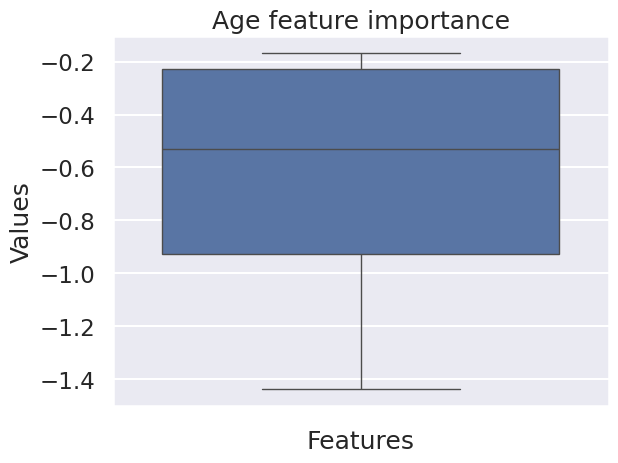

In [40]:
# Assuming 'last_part' is the extracted data from your tensor
# Converting the data into a Pandas DataFrame for use with Seaborn

# Plotting the boxplot with Seaborn
#plt.figure(figsize=(10, 6))
sns.boxplot(attributions[:,-2,0].cpu().numpy())
plt.title("Age feature importance")
plt.ylabel("Values")
plt.xlabel("Features")
plt.show()

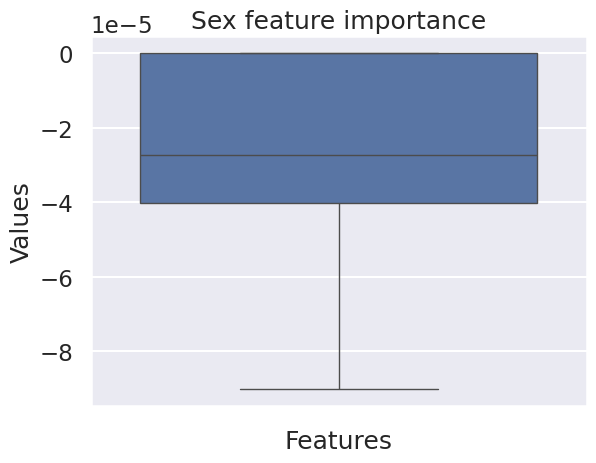

In [104]:
# Assuming 'last_part' is the extracted data from your tensor
# Converting the data into a Pandas DataFrame for use with Seaborn

# Plotting the boxplot with Seaborn
#plt.figure(figsize=(10, 6))
sns.boxplot(attributions[:,-1,0].cpu().numpy())
plt.title("Sex feature importance")
plt.ylabel("Values")
plt.xlabel("Features")
plt.show()

In [73]:
attributions[:,tk_ind.long()]

tensor([[[-0.0000e+00, -3.3899e-01,  0.0000e+00],
         [ 0.0000e+00,  3.8637e+00, -0.0000e+00],
         [-1.1195e-04, -0.0000e+00,  0.0000e+00],
         [-0.0000e+00,  0.0000e+00,  6.4410e-01],
         [-0.0000e+00,  3.1833e+00, -0.0000e+00],
         [ 0.0000e+00, -0.0000e+00,  2.2185e+00],
         [-0.0000e+00,  0.0000e+00,  4.2038e+00],
         [ 0.0000e+00,  2.2005e+00,  0.0000e+00],
         [-0.0000e+00,  2.0456e+00,  0.0000e+00],
         [-0.0000e+00, -0.0000e+00,  2.4657e+00]],

        [[-0.0000e+00, -0.0000e+00,  8.1467e+00],
         [ 0.0000e+00,  3.9782e+00, -0.0000e+00],
         [-0.0000e+00, -0.0000e+00,  1.9904e+00],
         [-0.0000e+00,  0.0000e+00,  6.6054e-01],
         [-0.0000e+00,  0.0000e+00, -8.2354e-03],
         [ 0.0000e+00, -0.0000e+00,  2.2196e+00],
         [-7.0968e-03,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  5.2161e-04],
         [-2.9434e-03,  0.0000e+00,  0.0000e+00],
         [-2.2911e-01, -0.0000e+00,  0.0000e+00]

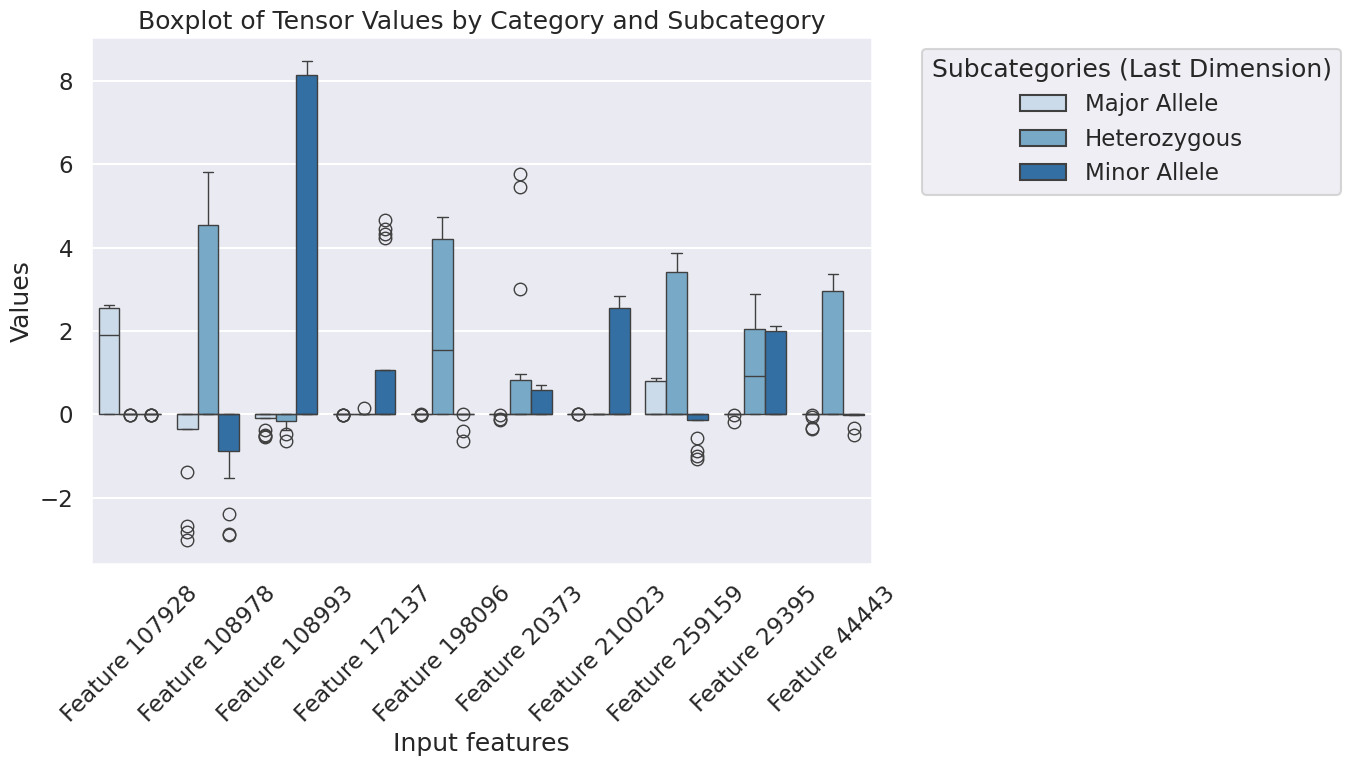

In [43]:
data = attributions[:,tk_ind.long()].cpu().numpy()  # Convert to NumPy array
reshaped_data = data.reshape(-1, 3)  # Reshape into (16*10, 3)

# Create a DataFrame for plotting
df = pd.DataFrame(reshaped_data, columns=['Major Allele', 'Heterozygous', 'Minor Allele'])
df['Category'] = pd.Categorical(
    [f"Feature {int(i)}" for i in tk_ind.long()] * 16  # Assign categories based on the second dimension
)
df['Sample'] = df.index // 10  # Assign a unique sample ID for each set of 10

# Step 3: Melt the DataFrame for Seaborn
df_melted = df.melt(id_vars=['Category', 'Sample'], var_name='Subcategory', value_name='Value')

# Step 4: Plot the boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_melted, x='Category', y='Value', hue='Subcategory', palette='Blues')

plt.title('Boxplot of Tensor Values by Category and Subcategory')
plt.xlabel('Input features')
plt.ylabel('Values')
plt.legend(title='Subcategories (Last Dimension)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [41]:
topk.indices/3

tensor([108993.6719, 198096.3438, 108978.3359, 107928.0000,  44443.3359,
        259159.3438, 210023.6719,  29395.3340, 172137.6719,  20373.3340],
       device='cuda:0')

In [92]:
topk.indices/3

tensor([108993.6719, 259159.3438, 296911.6875,  20373.3340,  44443.3359,
        413855.6875, 172137.6719, 328155.3438, 384584.3438, 354455.6875],
       device='cuda:0')

In [44]:
topk = torch.topk(abs_mean.flatten(), 20)
tk_ind = torch.floor(topk.indices/3)

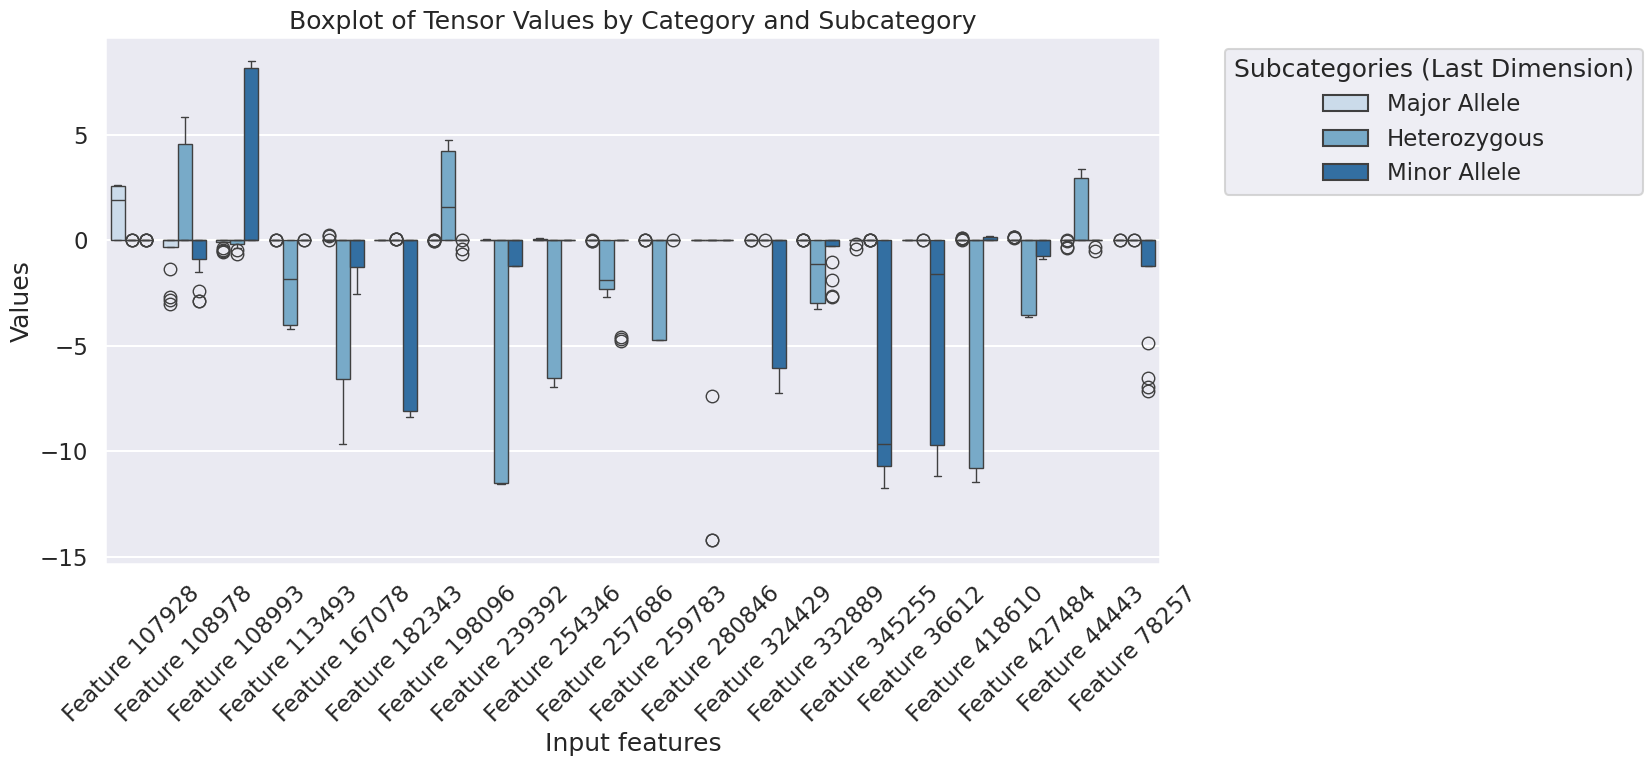

In [45]:
data = attributions[:,tk_ind.long()].cpu().numpy()  # Convert to NumPy array
reshaped_data = data.reshape(-1, 3)  # Reshape into (16*10, 3)

# Create a DataFrame for plotting
df = pd.DataFrame(reshaped_data, columns=['Major Allele', 'Heterozygous', 'Minor Allele'])
df['Category'] = pd.Categorical(
    [f"Feature {int(i)}" for i in tk_ind.long()] * 16  # Assign categories based on the second dimension
)
df['Sample'] = df.index // 10  # Assign a unique sample ID for each set of 10

# Step 3: Melt the DataFrame for Seaborn
df_melted = df.melt(id_vars=['Category', 'Sample'], var_name='Subcategory', value_name='Value')

# Step 4: Plot the boxplot
plt.figure(figsize=(17, 8))
sns.boxplot(data=df_melted, x='Category', y='Value', hue='Subcategory', palette='Blues')

plt.title('Boxplot of Tensor Values by Category and Subcategory')
plt.xlabel('Input features')
plt.ylabel('Values')
plt.legend(title='Subcategories (Last Dimension)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [46]:
# map back to snp id map
snp_id_map

{'rs13303101': 0,
 'rs192998324': 1,
 'rs55678698': 2,
 'rs2340588': 3,
 'rs146327803': 4,
 'rs41285790': 5,
 'rs9988179': 6,
 'rs74047407': 7,
 'rs2001730': 8,
 'rs77579483': 9,
 'Affx-89007868': 10,
 'rs1110052': 11,
 'rs199625867': 12,
 'Affx-89008640': 13,
 'rs200584816': 14,
 'Affx-52325915': 15,
 'Affx-80267079': 16,
 'rs200048444': 17,
 'rs3748592': 18,
 'rs3748593': 19,
 'rs144656266': 20,
 'rs74047418': 21,
 'rs144879626': 22,
 'Affx-80210141': 23,
 'rs2272757': 24,
 'rs35471880': 25,
 'rs139055451': 26,
 'rs67274836': 27,
 'rs114631528': 28,
 'Affx-80290518': 29,
 'Affx-15447216': 30,
 'rs3748597': 31,
 'rs13302945': 32,
 'Affx-80210145': 33,
 'rs3828049': 34,
 'Affx-89023000': 35,
 'rs13303065': 36,
 'rs112164716': 37,
 'Affx-80267082': 38,
 'Affx-80210147': 39,
 'rs144217019': 40,
 'Affx-80210148': 41,
 'rs115438739': 42,
 'rs13303010': 43,
 'Affx-52350436': 44,
 'rs138690517': 45,
 'Affx-80290520': 46,
 'rs6696971': 47,
 'rs147703918': 48,
 'rs199823418': 49,
 'Affx-920425

In [30]:
snp_df = pd.DataFrame.from_dict(snp_id_map, orient="index",columns=["snp_feature_id"])
snp_df

,snp_feature_id
rs13303101,0
rs192998324,1
rs55678698,2
rs2340588,3
rs146327803,4
...,...
Affx-34461837,429366
Affx-79381713,429367
Affx-89025698,429368
Affx-79381714,429369


In [31]:
snp_df.reset_index().set_index("snp_feature_id").loc[tk_ind.long().cpu()]

NameError: name 'tk_ind' is not defined

In [32]:
snp_df.reset_index().set_index("snp_feature_id").loc[113493]

index    rs6830036
Name: 113493, dtype: object

# Gene layer

In [12]:
# layer conductance
from captum.attr import LayerConductance

In [13]:
#cond = LayerConductance(model, model.model.model.gene_layer) # SNPs

In [14]:
#cond_vals = cond.attribute(input.cuda(), target=0, internal_batch_size=16)

In [13]:
cond = LayerConductance(model, model.model.model.graph_layer_0.linear2) # SNPs

In [47]:
model.model.model.graph_layer_0.linear2

SparseLinear(
  in_features=72296, out_features=18074, bias=False, sparsity=0.0013081356888085865, connectivity=tensor([[ 5473,  5473,  5473,  ...,  5572,  5572,  5572],
          [21892, 21893, 21894,  ..., 22289, 22290, 22291]]), small_world=False
)

In [34]:
input,_ = create_random_input()

In [36]:
cond_vals = cond.attribute(input.cuda(), target=0, internal_batch_size=64)

/cluster/project/beltrao/gankin/software/miniconda3/envs/mamba_env/envs/vnn/lib/python3.11/site-packages/captum/attr/_utils/batching.py:55: UserWarning: This method computes finite differences between evaluations at consecutive steps, so internal batch size must be at least twice the number of examples. Defaulting to internal batch size of 128 equal to twice the number of examples.
  warnings.warn(


In [14]:
from tqdm import tqdm

In [43]:
torch.cuda.empty_cache()

In [15]:
input,_ = create_random_input(batch_size=64)
cond_vals_gpu = cond.attribute(input.cuda(), target=0, internal_batch_size=64)
cond_vals = cond_vals_gpu.detach().cpu()
del cond_vals_gpu
torch.cuda.empty_cache()
for i in tqdm(range(0, 30)):
    input,_ = create_random_input(batch_size=64)
    cond_vals_gpu = cond.attribute(input.cuda(), target=0, internal_batch_size=64)
    cond_vals += cond_vals_gpu.detach().cpu()
    del cond_vals_gpu
    torch.cuda.empty_cache()

/cluster/project/beltrao/gankin/software/miniconda3/envs/mamba_env/envs/vnn/lib/python3.11/site-packages/captum/attr/_utils/batching.py:55: UserWarning: This method computes finite differences between evaluations at consecutive steps, so internal batch size must be at least twice the number of examples. Defaulting to internal batch size of 128 equal to twice the number of examples.
  warnings.warn(
100%|██████████| 30/30 [03:04<00:00,  6.14s/it]


In [17]:
avg_cond_vals = cond_vals/31

In [37]:
gene_att = avg_cond_vals.mean(dim=0) #avg_cond_vals.abs().mean(dim=0)
topk = torch.topk(gene_att,80)

In [38]:
systems_df = node_id_df.reset_index().set_index("node_id")

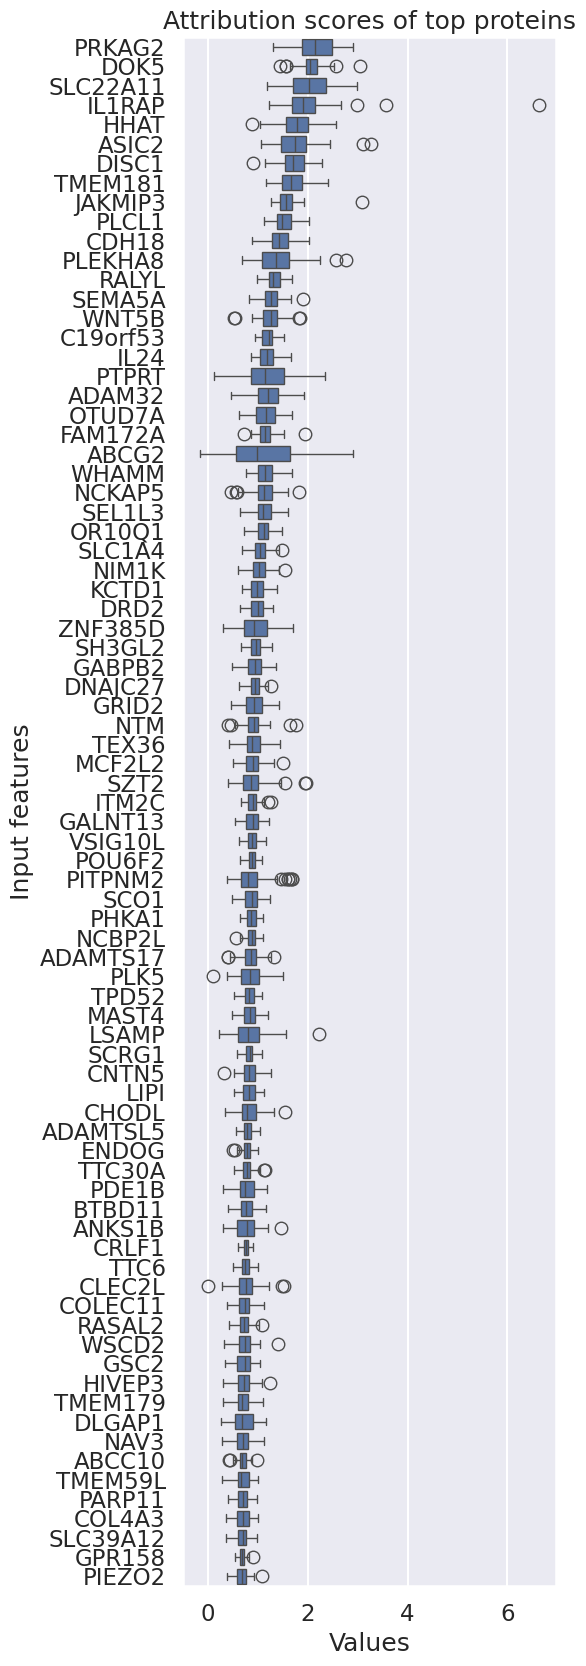

In [39]:
data = avg_cond_vals[:,topk.indices.long()].detach().numpy()  # Convert to NumPy array

# Create a DataFrame for plotting
df = pd.DataFrame(data, columns=[systems_df.loc[int(g)]["index"] for g in (topk.indices).long()])

# Step 3: Melt the DataFrame for Seaborn
df_melted = df.melt(var_name='Protein', value_name='Attribution score')

# Step 4: Plot the boxplot
plt.figure(figsize=(6, 17))
sns.boxplot(data=df_melted, y='Protein', x='Attribution score' )

plt.title('Attribution scores of top proteins')
plt.ylabel('Input features')
plt.xlabel('Values')
#plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [36]:
gene_att.numpy()

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.6462696e-08,
       1.2965338e-08, 4.2588066e-09], dtype=float32)

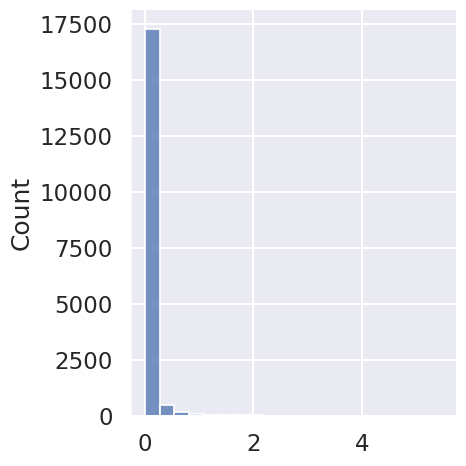

In [38]:
# plot distribution of the average values
sns.set_context("talk")
sns.displot(gene_att.numpy(), bins = 20)

In [ ]:
cond_vals.shape

torch.Size([16, 18074])

In [18]:
mean_att_abs = avg_cond_vals.abs().mean(dim=0)
mean_att = avg_cond_vals.mean(dim=0)
var_att = avg_cond_vals.var(dim=0)

In [ ]:
# create df
df = pd.DataFrame({"mean": mean_att.numpy(), "mean_abs": mean_att_abs.numpy(), "var": var_att.numpy()})
df

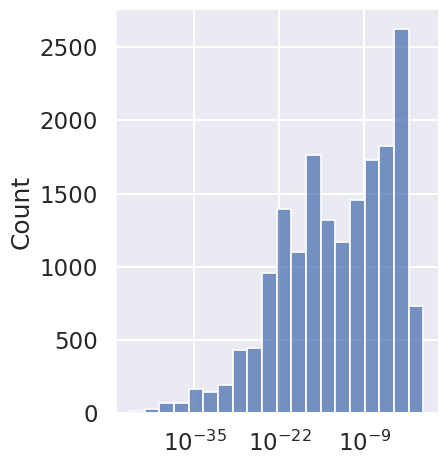

In [47]:
sns.displot(var_att.numpy(), bins = 20, log_scale=True)

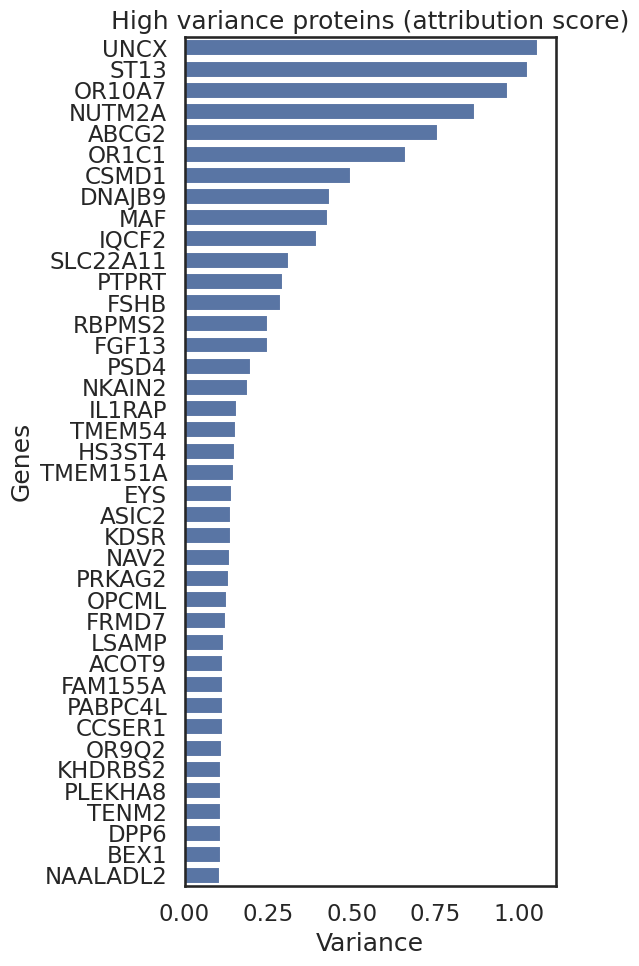

In [52]:
sns.set_theme(style="white", context="talk")

topk = torch.topk(var_att,40)

# Create a DataFrame for plotting
df = pd.DataFrame()
df["Variance of attribution score"] = topk.values.numpy()
df["Protein"] = [systems_df.loc[int(g)]["index"] for g in (topk.indices).long()]

# Step 4: Plot the boxplot
plt.figure(figsize=(6, 10))
sns.barplot(data=df, y='Protein', x='Variance of attribution score' )

plt.title('High variance proteins (attribution score)')
plt.ylabel('Genes')
plt.xlabel('Variance')
#plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [19]:
gwas_df = pd.read_csv("data/gout/gwas-association-downloaded_2024-11-20-EFO_0004274-withChildTraits.tsv", sep="\t")

In [56]:
gwas_df

,DATE ADDED TO CATALOG,PUBMEDID,FIRST AUTHOR,DATE,JOURNAL,LINK,STUDY,DISEASE/TRAIT,INITIAL SAMPLE SIZE,REPLICATION SAMPLE SIZE,...,PVALUE_MLOG,P-VALUE (TEXT),OR or BETA,95% CI (TEXT),PLATFORM [SNPS PASSING QC],CNV,MAPPED_TRAIT,MAPPED_TRAIT_URI,STUDY ACCESSION,GENOTYPING TECHNOLOGY
0,2022-07-19,35148957,Toyoda Y,2022-01-31,Mol Genet Metab,www.ncbi.nlm.nih.gov/pubmed/35148957,Genome-wide meta-analysis between renal overlo...,Renal overload gout,"486 renal overload-type gout male cases, 654 r...",NaN,...,8.221849,NaN,0.592325,[0.49643833629375-0.706731824325881],Illumina [7128846] (imputed),N,renal overload-type gout,http://www.ebi.ac.uk/efo/EFO_0021525,GCST90104597,Genome-wide genotyping array
1,2022-07-19,35148957,Toyoda Y,2022-01-31,Mol Genet Metab,www.ncbi.nlm.nih.gov/pubmed/35148957,Genome-wide meta-analysis between renal overlo...,Renal overload gout,"486 renal overload-type gout male cases, 654 r...",NaN,...,6.301030,NaN,0.612320,[0.505410655980108-0.741844222928925],Illumina [7128846] (imputed),N,renal overload-type gout,http://www.ebi.ac.uk/efo/EFO_0021525,GCST90104597,Genome-wide genotyping array
2,2022-07-19,35148957,Toyoda Y,2022-01-31,Mol Genet Metab,www.ncbi.nlm.nih.gov/pubmed/35148957,Genome-wide meta-analysis between renal overlo...,Renal overload gout,"486 renal overload-type gout male cases, 654 r...",NaN,...,6.221849,NaN,2.911010,[1.91599294999772-4.42276028482259],Illumina [7128846] (imputed),N,renal overload-type gout,http://www.ebi.ac.uk/efo/EFO_0021525,GCST90104597,Genome-wide genotyping array
3,2021-12-01,34737426,Jiang L,2021-11-04,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/34737426,A generalized linear mixed model association t...,Gout (PheCode 274.1),"375 European ancestry cases, 455,973 European ...",NaN,...,8.397940,NaN,5.540000,[3.7-7.38] unit increase,NR [11842647] (imputed),N,gout,http://www.ebi.ac.uk/efo/EFO_0004274,GCST90043662,Genome-wide genotyping array
4,2012-01-20,22179738,Lai HM,2011-12-16,Rheumatology (Oxford),www.ncbi.nlm.nih.gov/pubmed/22179738,Gout and type 2 diabetes have a mutual inter-d...,Gout,"20 Han Chinese ancestry male gout cases, 42 Ha...",NaN,...,7.000000,NaN,NaN,NaN,Illumina [479403],N,gout,http://www.ebi.ac.uk/efo/EFO_0004274,GCST001356,Genome-wide genotyping array
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,2019-10-29,31578528,Tin A,2019-10-02,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/31578528,"Target genes, variants, tissues and transcript...",Gout,"13,179 European, African American and unknown ...",NaN,...,290.000000,(EA),NaN,NaN,"Affymetrix, Illumina [8249849] (imputed)",N,gout,http://www.ebi.ac.uk/efo/EFO_0004274,GCST008970,Genome-wide genotyping array
294,2019-10-29,31578528,Tin A,2019-10-02,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/31578528,"Target genes, variants, tissues and transcript...",Gout,"13,179 European, African American and unknown ...",NaN,...,40.397940,(EA),NaN,NaN,"Affymetrix, Illumina [8249849] (imputed)",N,gout,http://www.ebi.ac.uk/efo/EFO_0004274,GCST008970,Genome-wide genotyping array
295,2019-10-29,31578528,Tin A,2019-10-02,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/31578528,"Target genes, variants, tissues and transcript...",Gout,"13,179 European, African American and unknown ...",NaN,...,31.096910,(EA),NaN,NaN,"Affymetrix, Illumina [8249849] (imputed)",N,gout,http://www.ebi.ac.uk/efo/EFO_0004274,GCST008970,Genome-wide genotyping array
296,2019-10-29,31578528,Tin A,2019-10-02,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/31578528,"Target genes, variants, tissues and transcript...",Gout,"13,179 European, African American and unknown ...",NaN,...,15.698970,(EA),NaN,NaN,"Affymetrix, Illumina [8249849] (imputed)",N,gout,http://www.ebi.ac.uk/efo/EFO_0004274,GCST008970,Genome-wide genotyping array


In [20]:
gwas_df.MAPPED_GENE.dropna().apply(lambda x: x.split(" - "))

0                     [ABCG2]
1        [SPATA31C2, RPSAP49]
2      [RN7SL318P, RPL23AP54]
3         [RUNX1T1, FLJ46284]
4                    [RBFOX1]
                ...          
293                   [ABCG2]
294                    [GCKR]
295                 [SLC17A1]
296                 [SLC16A9]
297                  [SFMBT1]
Name: MAPPED_GENE, Length: 290, dtype: object

In [21]:
gwas_genes = set()
for g in gwas_df.MAPPED_GENE.dropna().apply(lambda x: x.split(" - ")):
    gwas_genes.update(g)

len(gwas_genes)

221

In [22]:
node_id_df = pd.DataFrame.from_dict(model.model.model.node_id_mapping, orient="index",columns=["node_id"])

In [43]:
# plot attribution score dist for gwas genes vs all genes

# create dataframe with avg attribution
df = pd.DataFrame()
df["Average attribution"] = mean_att.numpy()
df["Average abs attribution"] = mean_att_abs.numpy()
df["Variance attribution"] = var_att.numpy()
df["Protein"] = node_id_df.index
df["GWAS gene"] = df.Protein.isin(gwas_genes)
df = df[~df.Protein.str.startswith("NEST")]

df

,Average attribution,Average abs attribution,Variance attribution,Protein,GWAS gene
4,9.799334e-02,9.799334e-02,9.864889e-04,PQLC1,False
5,2.222190e-03,2.222190e-03,1.080271e-06,OR1E2,False
6,-7.594309e-02,7.594309e-02,1.550298e-03,PIP5K1B,False
7,1.476646e-06,1.476646e-06,2.206216e-13,EBLN1,False
8,1.498904e-02,1.498904e-02,8.081715e-06,CBY1,False
...,...,...,...,...,...
18069,1.126387e-08,1.129201e-08,1.270699e-16,ZNF610,False
18070,2.946743e-08,2.946743e-08,3.817291e-16,ZFP62,False
18071,1.794775e-08,1.794775e-08,5.744877e-17,ZNF215,False
18072,1.692902e-08,1.695467e-08,1.873035e-16,ZNF224,False


<Axes: xlabel='GWAS gene', ylabel='Average attribution'>

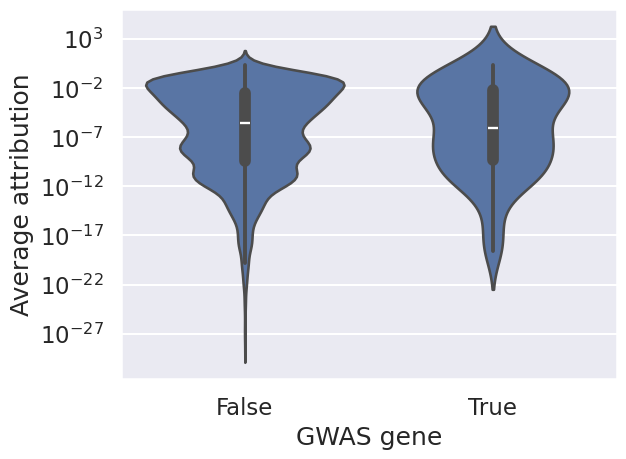

In [42]:
sns.violinplot(data=df, x="GWAS gene", y="Average attribution", log_scale=True)

/cluster/project/beltrao/gankin/software/miniconda3/envs/mamba_env/envs/vnn/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2842: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


ValueError: array must not contain infs or NaNs

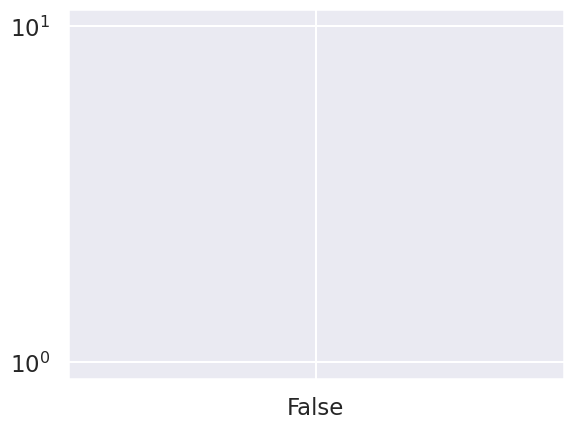

In [44]:
sns.violinplot(data=df, x="GWAS gene", y="Variance attribution", log_scale=True)

In [34]:
#sns.histplot(df["Average attribution"])

In [27]:
sns.set_context("talk")

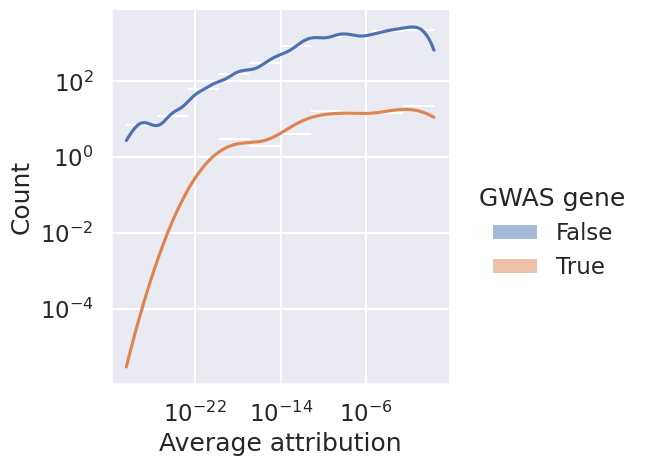

In [31]:
sns.displot(
    data=df,
    x="Average attribution",
    bins=10,
    log_scale=(True, True),  # Log scale on the y-axis
    label="All genes",
    kde=True,
    hue="GWAS gene",
)

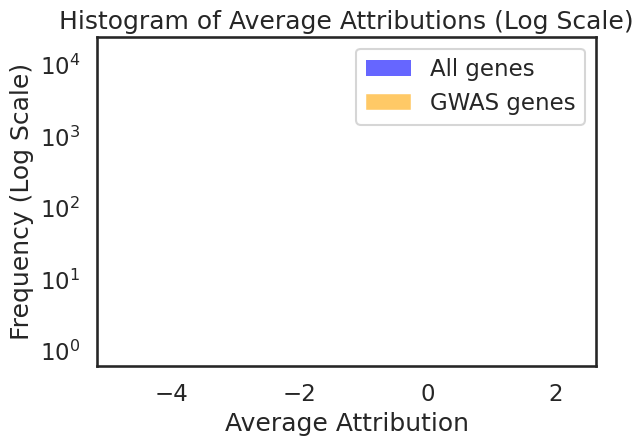

In [65]:
sns.histplot(
    data=df,
    x="Average attribution",
    bins=20,
    log_scale=(False, True),  # Log scale on the y-axis
    alpha=0.6,
    label="All genes",
)

# Step 2: Overlay the GWAS gene histogram
sns.histplot(
    data=df[df["GWAS gene"]],
    x="Average attribution",
    bins=20,
    log_scale=(False, True),  # Log scale on the y-axis
    kde=False,
    color="orange",
    alpha=0.6,
    label="GWAS genes",
)

# Customize the plot
plt.title("Histogram of Average Attributions (Log Scale)")
plt.xlabel("Average Attribution")
plt.ylabel("Frequency (Log Scale)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# map back to genes

In [66]:
max(list(model.model.model.node_id_mapping.values()))

18073

In [61]:
node_id_df = pd.DataFrame.from_dict(model.model.model.node_id_mapping, orient="index",columns=["node_id"])

In [62]:
node_id_df

,node_id
NEST,0
NEST_1,1
NEST_3,2
NEST_2,3
PQLC1,4
...,...
ZNF610,18069
ZFP62,18070
ZNF215,18071
ZNF224,18072


In [23]:
genes = [g for g in node_id_df.index if not g.startswith("NEST")]

In [ ]:
len(genes)

17679

In [27]:
node_id_df.loc[genes].reset_index().set_index("node_id")

,index
node_id,
4,PQLC1
5,OR1E2
6,PIP5K1B
7,EBLN1
8,CBY1
...,...
18069,ZNF610
18070,ZFP62
18071,ZNF215


In [36]:
node_id_df.loc[genes].reset_index().set_index("node_id").loc[4]["index"]

'PQLC1'

In [24]:
gene_ids = node_id_df.loc[genes].reset_index().set_index("node_id").index.values

In [78]:
gene_ids

array([    4,     5,     6, ..., 18071, 18072, 18073])

In [81]:
cond_vals[:,gene_ids]

tensor([[ 3.8999e-02, -9.9586e-04, -2.2753e-03,  ...,  1.2986e-08,
         -1.6382e-09,  4.8605e-11],
        [ 2.5833e-03,  1.3517e-03,  1.3602e-03,  ...,  6.4379e-08,
         -3.1271e-09,  2.5680e-11],
        [ 1.7782e-03,  7.2065e-04, -7.1593e-01,  ...,  2.7327e-08,
          6.2303e-08,  3.4687e-12],
        ...,
        [-7.4460e-04,  5.9091e-05,  3.8837e-03,  ...,  3.7180e-12,
          3.9156e-15,  5.8459e-14],
        [ 4.3327e-03, -9.3067e-05,  5.9394e-03,  ...,  2.8569e-12,
          1.4446e-14, -9.3147e-11],
        [ 9.9031e-04,  9.5472e-04, -3.1410e-02,  ...,  5.2698e-12,
          3.3257e-15, -9.0196e-11]], device='cuda:0', grad_fn=<IndexBackward0>)

In [78]:
gene_att = cond_vals.mean(dim=0).cpu()
topk = torch.topk(gene_att,40)

In [54]:
gene_att.shape

torch.Size([18074])

In [55]:
cond_vals.cpu()[:,topk.indices.long()].shape

torch.Size([16, 40])

In [23]:
systems_df = node_id_df.reset_index().set_index("node_id")

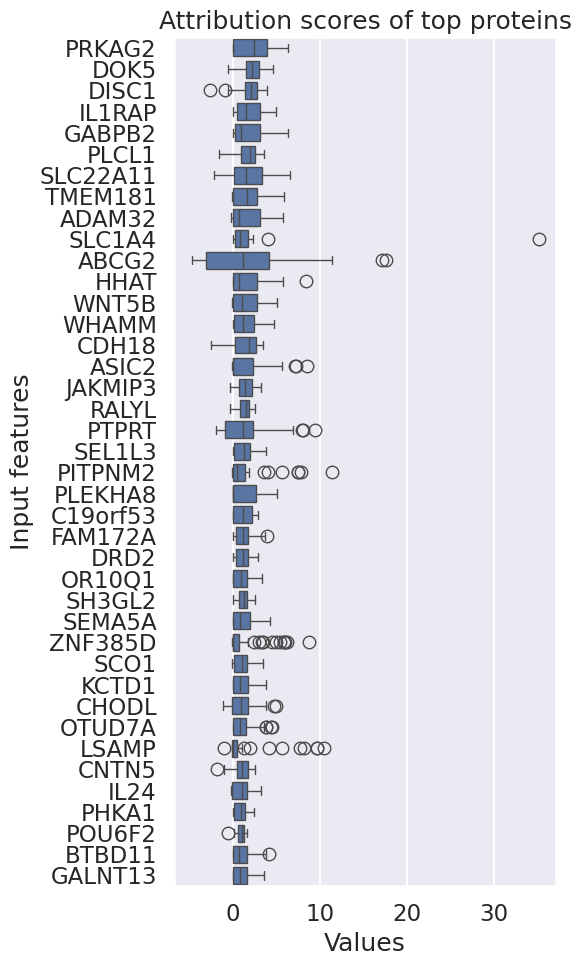

In [79]:
data = cond_vals.cpu()[:,topk.indices.long()].detach().numpy()  # Convert to NumPy array

# Create a DataFrame for plotting
df = pd.DataFrame(data, columns=[systems_df.loc[int(g)]["index"] for g in (topk.indices).long()])

# Step 3: Melt the DataFrame for Seaborn
df_melted = df.melt(var_name='Protein', value_name='Attribution score')

# Step 4: Plot the boxplot
plt.figure(figsize=(6, 10))
sns.boxplot(data=df_melted, y='Protein', x='Attribution score' )

plt.title('Attribution scores of top proteins')
plt.ylabel('Input features')
plt.xlabel('Values')
#plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

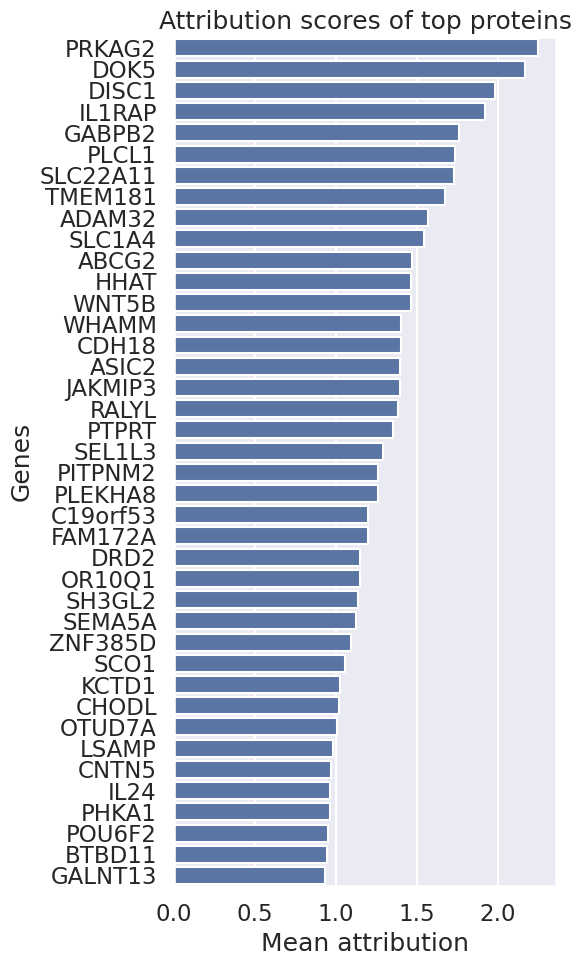

In [80]:
data = topk.values.detach().numpy()  # Convert to NumPy array

# Create a DataFrame for plotting
df = pd.DataFrame()
df["Mean attribution"] = data
df["Protein"] = [systems_df.loc[int(g)]["index"] for g in (topk.indices).long()]

# Step 4: Plot the boxplot
plt.figure(figsize=(6, 10))
sns.barplot(data=df, y='Protein', x='Mean attribution' )

plt.title('Attribution scores of top proteins')
plt.ylabel('Genes')
plt.xlabel('Mean attribution')
#plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

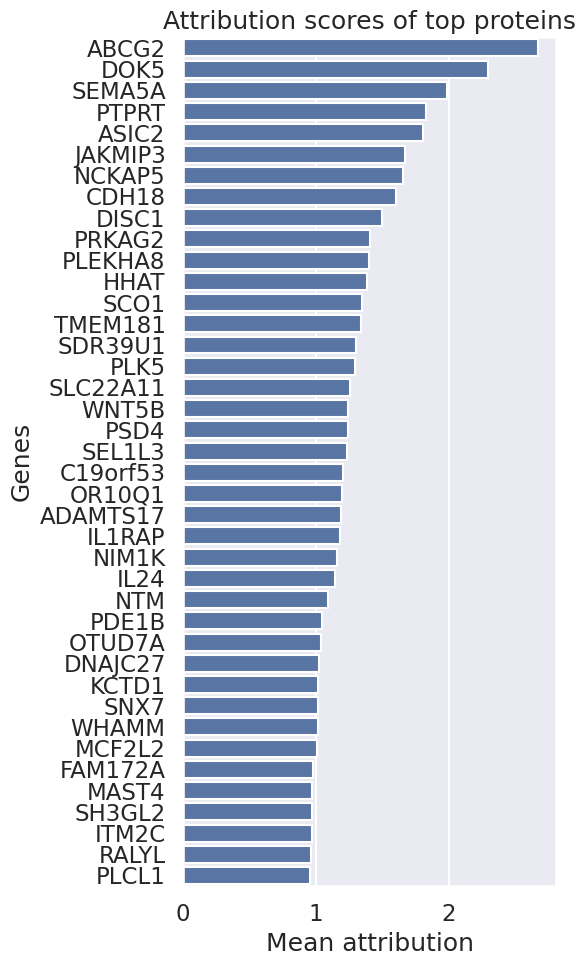

In [70]:
data = topk.values.detach().numpy()  # Convert to NumPy array

# Create a DataFrame for plotting
df = pd.DataFrame()
df["Mean attribution"] = data
df["Protein"] = [systems_df.loc[int(g)]["index"] for g in (topk.indices).long()]

# Step 4: Plot the boxplot
plt.figure(figsize=(6, 10))
sns.barplot(data=df, y='Protein', x='Mean attribution' )

plt.title('Attribution scores of top proteins')
plt.ylabel('Genes')
plt.xlabel('Mean attribution')
#plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [42]:
systems_df.loc[]

,index
node_id,
4,PQLC1
5,OR1E2
6,PIP5K1B
7,EBLN1
8,CBY1
...,...
18069,ZNF610
18070,ZFP62
18071,ZNF215


In [64]:
node_id_df.loc[["SLC2A9","ABCG2"]]

,node_id
SLC2A9,14605
ABCG2,2832


In [71]:
gene_att[14605]

tensor(4.5280e-07, grad_fn=<SelectBackward0>)